# Drug-Drug Similarity Based on the Taxonomy 


                                                                                by Alberto Olivares Alarcos

This notebook is part of the code developed into a Master Thesis and it is devoted to give a flavour of how to obtain a measurement of similarity between pairs of drugs by considering their taxonomic structure. As said before, this code is part of a Master Thesis, so we are not going to spend too much time explaining theoretical aspects. Please, if you have further interest in the project (e.g. knowing about the decision making), contact the author by e-mail: ***alberto.olivares.alarcos@gmail.com***.

## Background

The DrugBank database contains two kinds of different taxonomic structures: a field named 'Classification' and the ATC Codes$^{[1]}$. The taxonomy contains implicit information about the similarity of the drugs we can use for our purpose. For this project, we have chosen to use the first one (Classification) to build a graph which is used to compute the similarity among the drugs. The second graph (ATC Codes) is used to evaluate the result.  The classification has 5 in total levels, enumerated from the highest to the lowest:
- Kingdom - Organic or Inorganic
- Classes - drug classes form the major component of the classification system. Drugs with the same class are considered structurally similar.

The Classes are divided into:
- SuperClass, for example - ”Organic Acids”
- Class, for example - ”Carboxylic Acids and Derivatives”
- SubClass, for example - ”Amino Acids, Peptides, and Analogues”
- DirectParent, for example - ”Peptides” (can coincide with SubClass)

In our approach, similarity between drugs is computed using the graph structure in which they are organized. Thus, it is logically inevitable for us to build a graph in which the nodes are the drugs and the edges are the relationship between them. The semantics of our taxonomy has only one sort of relationship: 'is-a' relationship, (e.g. Acetaminophen is-a SubClass of Benzenoids, or which is the same, Benzenoids is-a SuperClass of Acetaminophen).

We have used the classification tag in the Drugbank database to construct 2 trees of 6 levels (depth equals to 5) which would connect the drugs in the database through undirected edges. Two different cases were contemplated: unweighted and weighted graphs. On the one hand, in unweighted graphs all the edges have the same meaning and value. On the other hand, in weighted graphs the cost of moving from one node to another is different depending on the level of the taxonomy in which the nodes are. This is to say, the edges between levels of the taxonomy imply a higher cost than edges between the same level.
The distance between drugs is calculated as a shortest path distance. For the case of the weighted graph, the higher the level of the closest common ancestor in the tree, the higher the weight for the distance. 

The motivation behind having two trees instead of one is because the drugs belong to either Organic or Inorganic kingdom, so we have not contemplated the most general class 'Drug'. Thus, we have decided that the path between those kingdoms should not exist, because of the very nature of the taxonomy (no or very little information gain). Additionally, introducing full connectivity (any drug can be reached from any drug in the database), by adding a common root, drastically increases computation time.

There are three main approaches to compute distances among concepts organized in a taxonomic structure: path-based (weighted and unweighted), density-based and information/content-based. In this project, we use the first one in its two forms (when the graph's edges are weighted and not.

Specifically, compute the distance between every pair of drugs as the length of the path between them. In the cases in which there is no path, we set the distance to -1. There exist several ways of turning those distances into similarities though, we have chosen the method proposed by Leacock and Chodorow ~\cite{leacock1998combining}. The Leacock ando Chodorow Simiarily between two nodes of a graph (drugs, in this case, d1 and d2) is as follows:

$$Sim(d1,d2)=-\log\bigg(\frac{length}{2D}\bigg)$$

Where length is the length of the shortest path between the two concepts (using node-counting) and D is the maximum depth of the taxonomy. Based on this measure, the shortest path between two concepts of the ontology restricted to taxonomic links is normalized by introducing a division by the double of the maximum hierarchy depth.

[1] The Anatomical Therapeutic Chemical (ATC) Classification System is used for the classification of active ingredients of drugs according to the organ or system on which they act and their therapeutic, pharmacological and chemical properties.

## Evaluation

There are two main sorts of evaluation: direct and indirect. On the one hand, a direct evaluation is the one performed directly over the result you want to study. On the other hand, an indirect evaluation is the one in which you use the obtained result to solve a task and then you evaluate the performance of it over the task. Normally, the ideal evaluation is a direct one, in which the result is compared with a *'golden standard'*. However,it is difficult to evaluate our work since there is not any clear *'golden standard'* to compare our results with. 

In this project, we have performed two different evaluations over the computed similarities:


- **Clustering.** This is an example of indirect evaluation. We have used the similarities to cluster the drugs into groups. Then, we study the ATC Code distribution of those clusters in order to check if our similarity measurements are good. The reason why we use the ATC Code to evaluate is because we have cluster into 14 clusters (the same number of categories of the first level of ATC Code). We did not want to add much theory in this notebook, for that, ask for the Master Thesis documentation to the author. 

- **Ground Truth.** This evaluation is a small direct evaluation we have done with a ground truth annotated by experts in the domain. The similarity of a list of 100 pairs of drugs were annotated by 143 experts. We have taken it from a paper named: *'The use of 2D fingerprint methods to support the assessment of structural similarity in orphan drug legislation'*. Authors provide a file with this information in the webpage of the journey$^{[1]}$. and modified and adapted to our convenience. We compare the similarity computed for us with the similarity following the experts's opinion. 

|1] https://link.springer.com/article/10.1186/1758-2946-6-5

## IMPLEMENTATION

In [1]:
# Headers 
import sys
import os
import time
import numpy
import csv
import networkx as nx
from operator import itemgetter
import matplotlib.pyplot as plt
from IPython.display import Image
from sklearn.cluster import SpectralClustering

HERE = os.path.abspath(os.path.dirname("__file__"))
sys.path.append(os.path.join(HERE, ".."))

from utils.drugbank_accessor_ET import *
from utils.general_utils import *
from utils.graph_utils import *
from utils.evaluation_utils import *

print("Done")

Done


In [2]:
# Reading the corpus and creating a dictionary of drugs. 
zip_filepath = './../corpus/drugbank.xml_release_2017_12_20.zip' # Version 5.0.11
filename = 'drugbank.xml'

file = read_zip_file(zip_filepath, filename)
drugs = map_drugbank_from_file(file)
print(len(drugs))

ids = sorted(drugs.keys())
ids_dic = dict(enumerate(ids))

1661


In [3]:
# Building two graphs (unweighted and weighted)
print('Building unweighted graph..')
unweighted_graph = build_classification_graph_from_list(list(drugs.values()))
print('Built..')

print('Building weighted graph..')
weighted_graph = build_classification_weighted_graph_from_list(list(drugs.values()))
print('Built..')

Building unweighted graph..
Built..
Building weighted graph..
Built..


In [4]:
# Characteristics of the weighted graph

print(nx.info(weighted_graph))
print(nx.is_directed(weighted_graph))
print("radius: %d" % nx.radius(weighted_graph))
#print("diameter: %d" % nx.diameter(weighted_graph))
#print("eccentricity: %s" % nx.eccentricity(unweighted_graph))
print("center: %s" % nx.center(weighted_graph))
print("periphery: %s" % nx.periphery(weighted_graph))
print("density: %s" % nx.density(weighted_graph))
#print(nx.degree(weighted_graph))

Name: 
Type: Graph
Number of nodes: 2360
Number of edges: 2452
Average degree:   2.0780
False
radius: 7
center: ['Organic acids and derivatives']
periphery: ['DB09165', 'Organic Compounds', 'DB09353', 'DB00761', 'DB09140', 'DB00971', 'DB09407', 'DB09322', 'DB11348', 'DB09321', 'DB06723', 'DB01574', 'DB09104', 'DB00653', 'DB00515', 'DB09157', 'DB01169', 'DB06715', 'DB09325', 'DB09153', 'DB11092', 'DB09449', 'DB09472', 'DB00435', 'DB01164', 'DB01575', 'DB09112']
density: 0.000880867359768934


In [5]:
# Characteristics of the unweighted graph

print(nx.info(unweighted_graph))
print(nx.is_directed(unweighted_graph))
print("radius: %d" % nx.radius(unweighted_graph))
#print("diameter: %d" % nx.diameter(weighted_graph))
#print("eccentricity: %s" % nx.eccentricity(unweighted_graph))
print("center: %s" % nx.center(unweighted_graph))
print("periphery: %s" % nx.periphery(unweighted_graph))
print("density: %s" % nx.density(unweighted_graph))
#print(nx.degree(weighted_graph))

Name: 
Type: Graph
Number of nodes: 2360
Number of edges: 2452
Average degree:   2.0780
False
radius: 7
center: ['Organic acids and derivatives']
periphery: ['DB09165', 'Organic Compounds', 'DB09353', 'DB00761', 'DB09140', 'DB00971', 'DB09407', 'DB09322', 'DB11348', 'DB09321', 'DB06723', 'DB01574', 'DB09104', 'DB00653', 'DB00515', 'DB09157', 'DB01169', 'DB06715', 'DB09325', 'DB09153', 'DB11092', 'DB09449', 'DB09472', 'DB00435', 'DB01164', 'DB01575', 'DB09112']
density: 0.000880867359768934


## DISTANCE MATRICES

In [6]:
# Computing distance matrices for both cases
start = time.time()
if not(os.path.exists('./../data/graph/unweighted_dist_matrix.npy')):
    unweighted_matrix = calculate_dist_matrix(unweighted_graph, list(drugs.keys()))
    numpy.save('./../data/graph/unweighted_dist_matrix.npy', unweighted_matrix)
else: 
    unweighted_matrix = numpy.load('./../data/graph/unweighted_dist_matrix.npy')
print('Computed Unweighted Distance Matrix')
end = time.time()
print("Execution Time (s): " + str(end - start))  

if not(os.path.exists('./../data/graph/weighted_dist_matrix.npy')):
    weighted_matrix = calculate_weighted_dist_matrix(weighted_graph, list(drugs.keys()))
    numpy.save('./../data/graph/weighted_dist_matrix.npy', weighted_matrix)
else: 
    weighted_matrix = numpy.load('./../data/graph/weighted_dist_matrix.npy')
print('Computed Weighted Distance Matrix')
end = time.time()
print("Execution Time (s): " + str(end - start))  

Computed Unweighted Distance Matrix
Execution Time (s): 0.05134773254394531
Computed Weighted Distance Matrix
Execution Time (s): 0.07659363746643066


In [7]:
# We need to normalize the distance matrix and then compute the similarity matrix 
start = time.time()
if not(os.path.exists('./../data/graph/unweighted_sim_matrix.npy')) or not(os.path.exists('./../data/graph/norm_unweighted_sim_matrix.npy')):
    unweighted_sim_matrix = leakcock_chodorow_measure(unweighted_matrix)
    norm_unweighted_sim_matrix = normalize_matrix(unweighted_sim_matrix)
    numpy.save('./../data/graph/unweighted_sim_matrix.npy', unweighted_sim_matrix)
    numpy.save('./../data/graph/norm_unweighted_sim_matrix.npy', norm_unweighted_sim_matrix)
else: 
    unweighted_sim_matrix = numpy.load('./../data/graph/unweighted_sim_matrix.npy')
    norm_unweighted_sim_matrix = numpy.load('./../data/graph/norm_unweighted_sim_matrix.npy')
print('Computed Unweighted Similarity Matrix')
end = time.time()
print("Execution Time (s): " + str(end - start))

if not(os.path.exists('./../data/graph/weighted_sim_matrix.npy')) or not(os.path.exists('./../data/graph/norm_weighted_sim_matrix.npy')):
    weighted_sim_matrix = leakcock_chodorow_measure(weighted_matrix)
    norm_weighted_sim_matrix = normalize_matrix(weighted_sim_matrix)
    numpy.save('./../data/graph/weighted_sim_matrix.npy', weighted_sim_matrix)
    numpy.save('./../data/graph/norm_weighted_sim_matrix.npy', norm_weighted_sim_matrix)
else: 
    weighted_sim_matrix = numpy.load('./../data/graph/weighted_sim_matrix.npy')
    norm_weighted_sim_matrix = numpy.load('./../data/graph/norm_weighted_sim_matrix.npy')
print('Computed Weighted Similarity Matrix')
end = time.time()
print("Execution Time (s): " + str(end - start))

Computed Unweighted Similarity Matrix
Execution Time (s): 0.07060742378234863
Computed Weighted Similarity Matrix
Execution Time (s): 0.1188504695892334


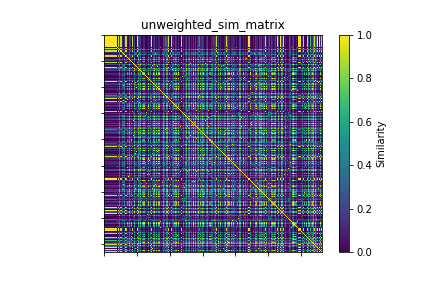

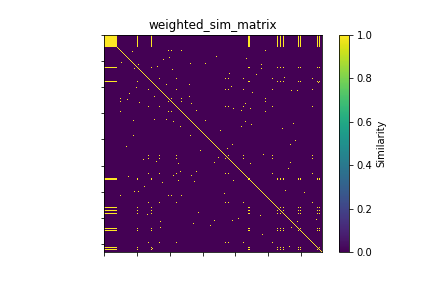

In [9]:
# Visual evaluation of Similarity
display_plots = True
path_images = './../plots/graph/'

if not(os.path.exists('./../plots/graph/unweighted_sim_matrix.png')):
    save_similarity_matrix(numpy.array(unweighted_sim_matrix), path_images, \
                       'unweighted_sim_matrix')
else: 
    if display_plots:
        img = Image(filename = path_images + "unweighted_sim_matrix.png", width=500, height=500)
        display(img)
    
if not(os.path.exists('./../plots/graph/weighted_sim_matrix.png')):
    save_similarity_matrix(numpy.array(weighted_sim_matrix), path_images, \
                       'weighted_sim_matrix')
else: 
    if display_plots:
        img = Image(filename = path_images + "weighted_sim_matrix.png", width=500, height=500)
        display(img)

## EVALUATION

As said before, two different evaluations are done: indirect (clustering) and direct (ground truth). 

### EVALUATION: CLUSTERING

**NOTE... If you want to save the images of the histograms of the clusters distribution, modify the variable 'save_histograms' to True. Take into account that you will overwrite the previous images. You can also display or not the histograms and similarity matrices which are already on the folder of plots if you put the variable 'display_plots' to True.**

In [10]:
# Definition of variables
nclust = 14

save_histograms = False
display_plots = True

Total ATC:  3007


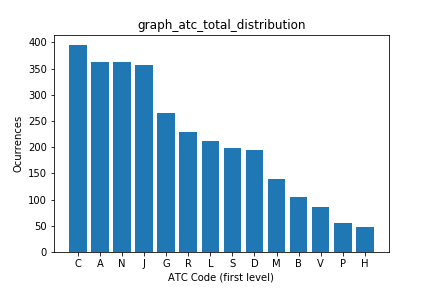

In [11]:
# Distribution of ATC Codes first level of the total set of used drugs
    
atc_first_level_all_drugs = list()
for db_id in ids:
    atc_codes_dbid = getattr(drugs[db_id], 'atc_codes')
    for atc_code in atc_codes_dbid:
        atc_first_level_all_drugs.append(atc_code[0])

print('Total ATC: ', len(atc_first_level_all_drugs))

path_images = './../plots/evaluation/clustering/graph/'

if not (os.path.exists('./../plots/evaluation/clustering/graph/graph_atc_total_distribution.png')):
    save_histogram(atc_first_level_all_drugs, path_images, \
                       'graph_atc_total_distribution')
else: 
    img = Image(filename = path_images + 'graph_atc_total_distribution.png', width=500, height=500)
    display(img)
    

In [12]:
# Spectral Clustering
sca_uw = SpectralClustering(affinity="precomputed", n_clusters=nclust)
sca_uw.fit(norm_unweighted_sim_matrix)

sca_w = SpectralClustering(affinity="precomputed", n_clusters=nclust)
sca_w.fit(norm_weighted_sim_matrix)

/usr/lib/python3/dist-packages/scipy/sparse/csgraph/_laplacian.py:71: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if normed and (np.issubdtype(csgraph.dtype, int)


SpectralClustering(affinity='precomputed', assign_labels='kmeans', coef0=1,
          degree=3, eigen_solver=None, eigen_tol=0.0, gamma=1.0,
          kernel_params=None, n_clusters=14, n_init=10, n_jobs=1,
          n_neighbors=10, random_state=None)

In [13]:
# Extracting the clusters
clusters_idx_uw = label_idx(sca_uw.labels_, nclust)
clusters_idx_w = label_idx(sca_w.labels_, nclust)

clusters_dbid_uw = dict()
clusters_dbid_w = dict()

for l in clusters_idx_uw.keys():
     clusters_dbid_uw[l] = idx_to_id(clusters_idx_uw[l], ids_dic)
        
for l in clusters_idx_w.keys():
     clusters_dbid_w[l] = idx_to_id(clusters_idx_w[l], ids_dic)

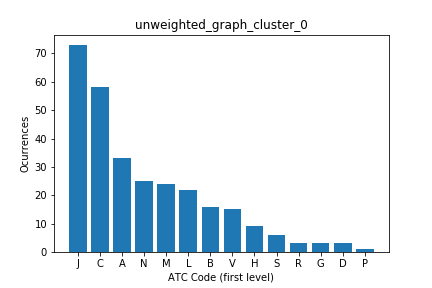

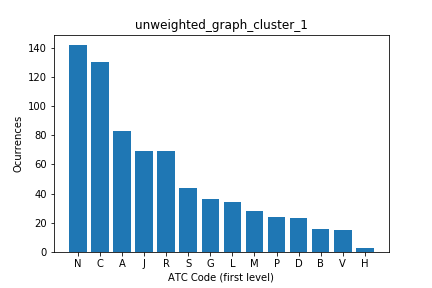

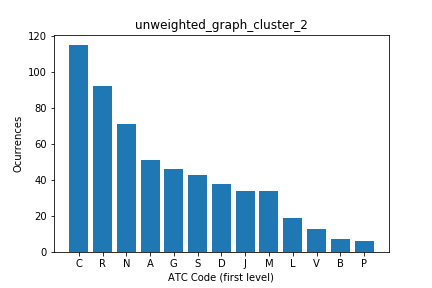

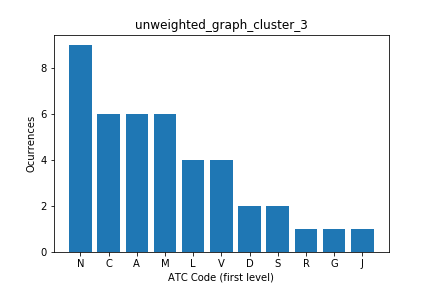

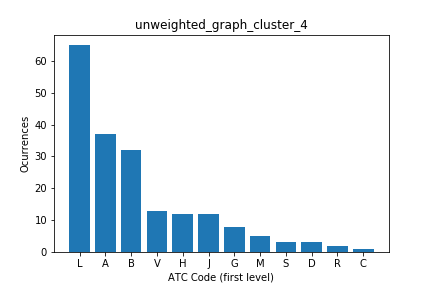

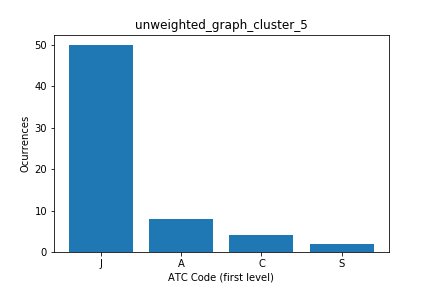

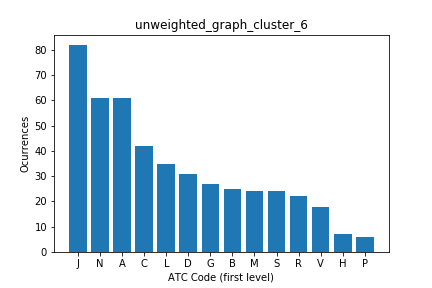

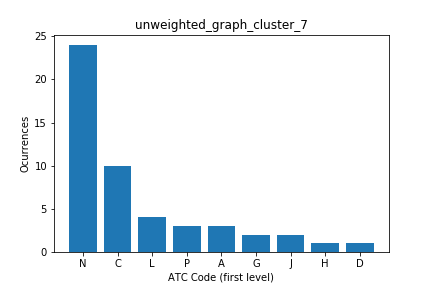

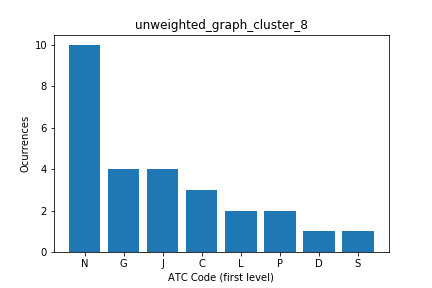

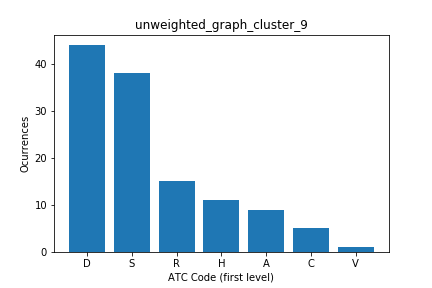

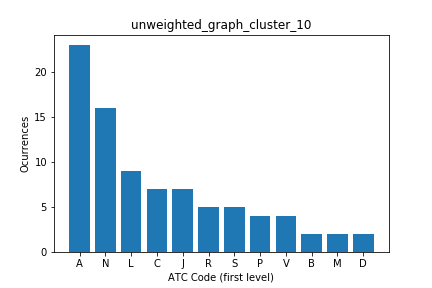

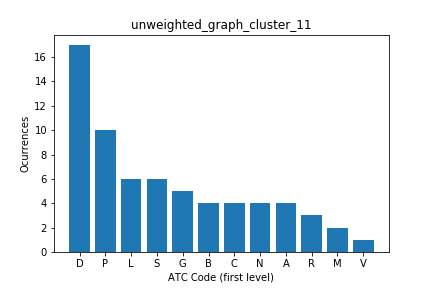

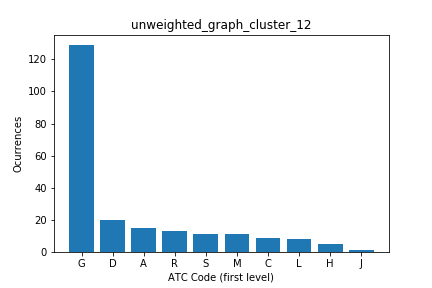

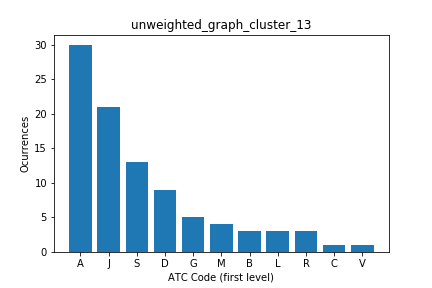

In [14]:
# Clusters ATC code distribution for Unweighted Graph
clusters_ATC_distribution = dict()
for cluster, drugbank_ids in clusters_dbid_uw.items():
    atc_first_level_for_one_cluster = list()
    for db_id in drugbank_ids:
        atc_codes_dbid = getattr(drugs[db_id], 'atc_codes')
        for atc_code in atc_codes_dbid:
            atc_first_level_for_one_cluster.append(atc_code[0])
    clusters_ATC_distribution[cluster] = atc_first_level_for_one_cluster
    
path_images = './../plots/evaluation/clustering/graph/'

for i in range (0, len(clusters_ATC_distribution)):
    if not(os.path.exists('./../plots/evaluation/clustering/graph/unweighted_graph_cluster_'+str(i)+'.png'))\
          or save_histograms:
        save_histogram(clusters_ATC_distribution[i], path_images, \
                           'unweighted_graph_cluster_'+str(i))
    else: 
        if display_plots:
            img = Image(filename = path_images + 'unweighted_graph_cluster_'+str(i)+'.png', width=500, height=500)
            display(img)

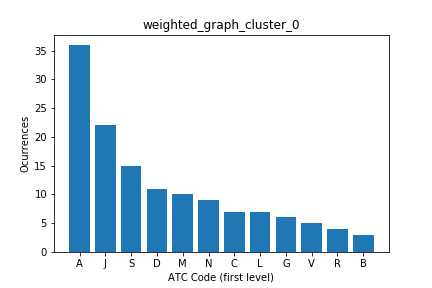

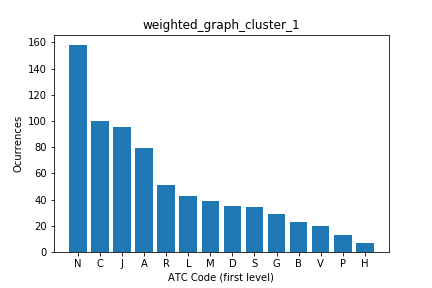

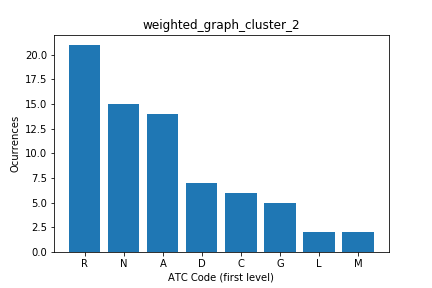

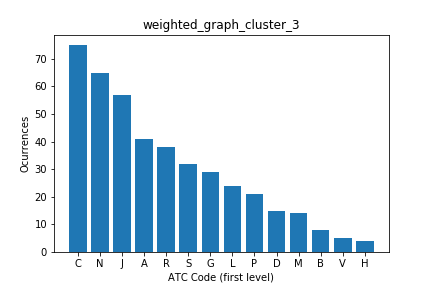

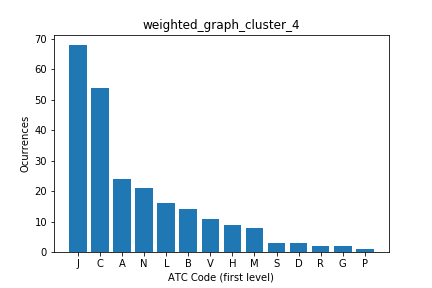

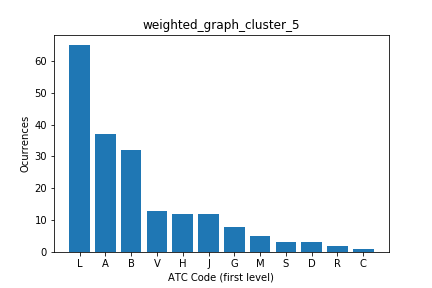

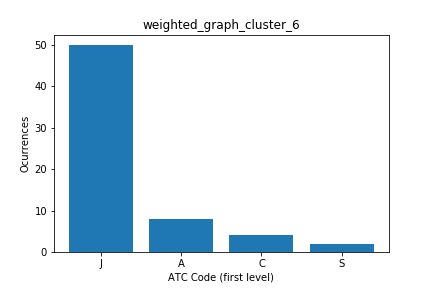

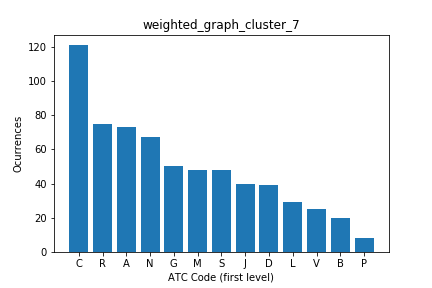

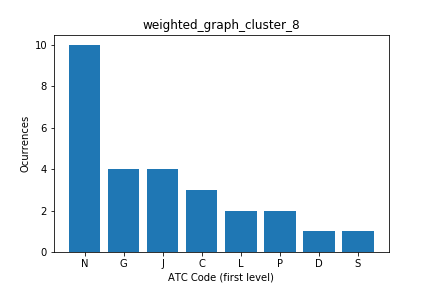

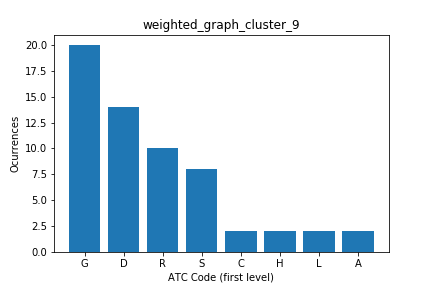

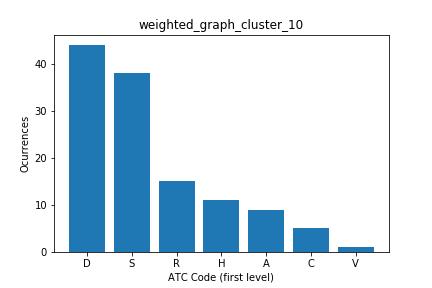

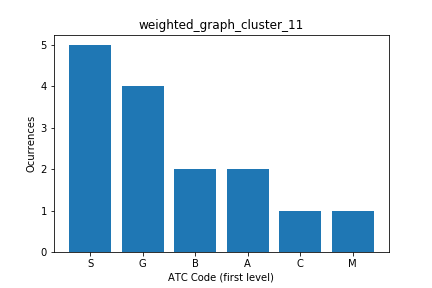

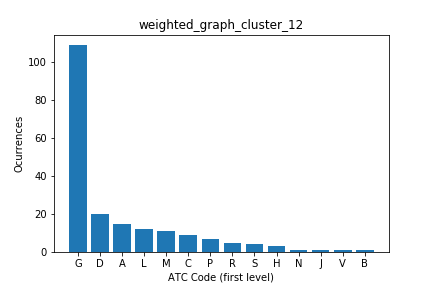

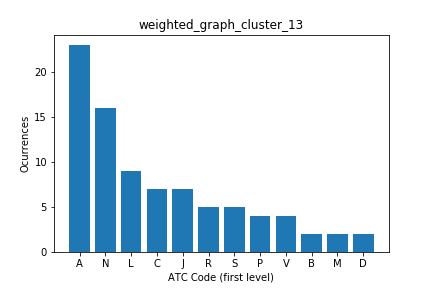

In [15]:
# Clusters ATC code distribution for Unweighted Graph
clusters_ATC_distribution = dict()
for cluster, drugbank_ids in clusters_dbid_w.items():
    atc_first_level_for_one_cluster = list()
    for db_id in drugbank_ids:
        atc_codes_dbid = getattr(drugs[db_id], 'atc_codes')
        for atc_code in atc_codes_dbid:
            atc_first_level_for_one_cluster.append(atc_code[0])
    clusters_ATC_distribution[cluster] = atc_first_level_for_one_cluster
    
path_images = './../plots/evaluation/clustering/graph/'

for i in range (0, len(clusters_ATC_distribution)):
    if not(os.path.exists('./../plots/evaluation/clustering/graph/weighted_graph_cluster_'+str(i)+'.png'))\
    or save_histograms:
        save_histogram(clusters_ATC_distribution[i], path_images, \
                           'weighted_graph_cluster_'+str(i))
    else: 
        if display_plots:
            img = Image(filename = path_images + 'weighted_graph_cluster_'+str(i)+'.png', width=500, height=500)
            display(img)

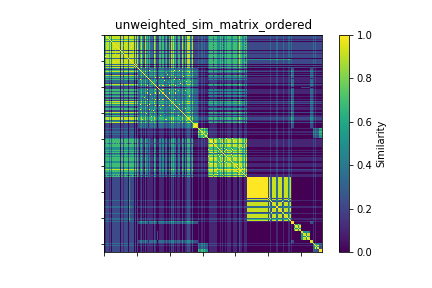

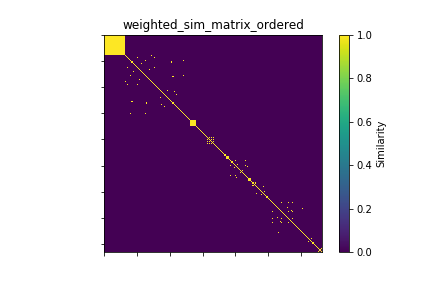

In [16]:
# Order the similarity matrices according to clusters
path_images = './../plots/graph/'

clusters_idx_ordered = list()
for i in range(nclust):
    clusters_idx_ordered += clusters_idx_uw[i]
    
if not(os.path.exists('./../plots/graph/unweighted_sim_matrix_ordered.png')):
    save_similarity_matrix_ordered(numpy.array(unweighted_sim_matrix), clusters_idx_ordered, \
                                   path_images, 'unweighted_sim_matrix_ordered')
else: 
    if display_plots:
        img = Image(filename = path_images + "unweighted_sim_matrix_ordered.png", width=500, height=500)
        display(img)

clusters_idx_ordered = list()
for i in range(nclust):
    clusters_idx_ordered += clusters_idx_w[i]
if not(os.path.exists('./../plots/graph/weighted_sim_matrix_ordered.png')):
    save_similarity_matrix_ordered(numpy.array(weighted_sim_matrix), clusters_idx_ordered, \
                                   path_images, 'weighted_sim_matrix_ordered')
else:
    if display_plots:
        img = Image(filename = path_images + "weighted_sim_matrix_ordered.png", width=500, height=500)
        display(img)

### EVALUATION: GROUND TRUTH
Here we evaluate three different things: two correlations (if the order infered by the similarity values is the same in the pairs and the correlation among the values of similarities predicted) and the accuracy and recall of the classification.


In [17]:
# Extract similarity for a list of pairs from a Similarity Matrix
ground_truth_path = '../data/evaluation/ground_truth.csv'
with open(ground_truth_path, 'rt') as csvfile:
    reader = csv.reader(csvfile)
    ground_truth_list = list(reader)
    
# We add an id for each pair (in order to evaluate afterwards the order infered by the similarity values)
for i in range(0, len(ground_truth_list)):
    ground_truth_list[i].append(i)

computed_weighted_similarity_list = compute_similarity_between_pairs(ids, norm_weighted_sim_matrix, ground_truth_list)
computed_unweighted_similarity_list = compute_similarity_between_pairs(ids, norm_unweighted_sim_matrix, ground_truth_list)

In [18]:
# Count number of pairs which actually are within our matrix
n = len(computed_weighted_similarity_list)
counter = 0
for i in range(0, n):
    if computed_weighted_similarity_list[i][2] == -1:
        counter += 1

In [19]:
print("The total of pairs from the ground truth is: ", n)
print("The number of pairs we have from the total is: ", n - counter) # number of drugs which actually are in our matrix of similarity..

The total of pairs from the ground truth is:  97
The number of pairs we have from the total is:  65


In [20]:
# Evaluation..

# Necessary to not contemplate pairs which are not among our computed similarities (for the order correlation)
computed_weighted_similarity_list_match = list()
computed_unweighted_similarity_list_match = list()
ground_truth_list_match = list()
for i in range(0, len(computed_weighted_similarity_list)):
    if not computed_weighted_similarity_list[i][2] == -1:
        computed_weighted_similarity_list_match.append(computed_weighted_similarity_list[i])
        computed_unweighted_similarity_list_match.append(computed_unweighted_similarity_list[i])
        ground_truth_list_match.append(ground_truth_list[i])
        
ground_truth_list_ordered = sorted(ground_truth_list_match, key=itemgetter(2)) # From 0 to 1 (similarity)
computed_weighted_similarity_list_ordered = sorted(computed_weighted_similarity_list_match, key=itemgetter(2))
computed_unweighted_similarity_list_ordered = sorted(computed_unweighted_similarity_list_match, key=itemgetter(2))

print("Correlation (weighted)")
corr_order = ground_truth_evaluation_order(computed_weighted_similarity_list_ordered, ground_truth_list_ordered)
print("Order", corr_order)
corr_value = ground_truth_evaluation_value(computed_weighted_similarity_list, ground_truth_list)
print("Value", corr_value)
acc_threshold, recall_threshold = ground_truth_evaluation_threshold(computed_weighted_similarity_list, ground_truth_list, 0.85)
print("Accuracy, Recall: ",acc_threshold, recall_threshold)

print("\nCorrelation (unweighted)")
corr_order = ground_truth_evaluation_order(computed_unweighted_similarity_list_ordered, ground_truth_list_ordered)
print("Order", corr_order)
corr_value = ground_truth_evaluation_value(computed_unweighted_similarity_list, ground_truth_list)
print("Value", corr_value)
acc_threshold, recall_threshold = ground_truth_evaluation_threshold(computed_unweighted_similarity_list, ground_truth_list, 0.85)
print("Accuracy, Recall: ",acc_threshold, recall_threshold)

Correlation (weighted)
Order KendalltauResult(correlation=0.06730769230769229, pvalue=0.4280144622250214)
Value (0.6997658565592045, 8.833456391041982e-11)
Accuracy, Recall:  0.7692307692307693 0.7777777777777778

Correlation (unweighted)
Order KendalltauResult(correlation=0.22115384615384612, pvalue=0.00920790304464506)
Value (0.6720731665117535, 8.807878285881234e-10)
Accuracy, Recall:  0.7538461538461538 0.7222222222222222
